In [3]:
from typing import Callable, List, Tuple
from tiler import Tiler, Merger
import numpy as np
import catalyst
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import subprocess

class cd:
    """Context manager for changing the current working directory"""
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

In [61]:
from pathlib import Path

ROOT = Path(os.getcwd())
l_grid=5

soft_images_folder = ROOT / "images_original/soft_train_images"
soft_masks_folder = ROOT / "masks/soft_train_masks"

tiled_image_path = ROOT / f"images_original/tiled_train_images_{l_grid}"
tiled_mask_path = ROOT / f"masks/tiled_train_masks_{l_grid}"

training = ['settembre_2019', 'ottobre_2019', 'settembre_2020', '11_dic_2020', '18_dic_2020']

for fold in [soft_images_folder, soft_masks_folder, tiled_image_path, tiled_mask_path]:
    if os.path.exists(fold):
        shutil.rmtree(fold)
    os.mkdir(fold)
    
with cd(soft_images_folder):
    for subfold in training:
        os.system(f'cp -s ../{subfold}/* .')
        
with cd(soft_masks_folder):
    for subfold in training:
        os.system(f'cp -s ../{subfold}/* .')


# image_path = ROOT / "images_original/train_images"
# mask_path = ROOT / "masks/train_masks"

In [62]:
ALL_IMAGES = sorted(soft_images_folder.glob("*.jpg"))
ALL_MASKS = sorted(soft_masks_folder.glob("*.png"))

print(f"Masks:{len(ALL_MASKS)}")
print(f"Images:{len(ALL_IMAGES)}")

Masks:857
Images:857


---
### Tiling test

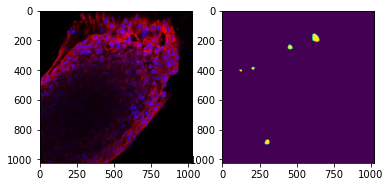

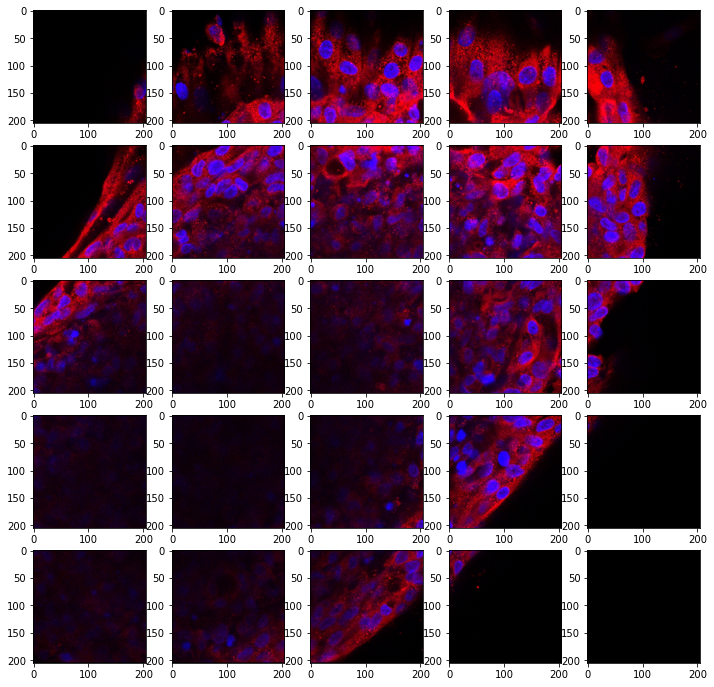

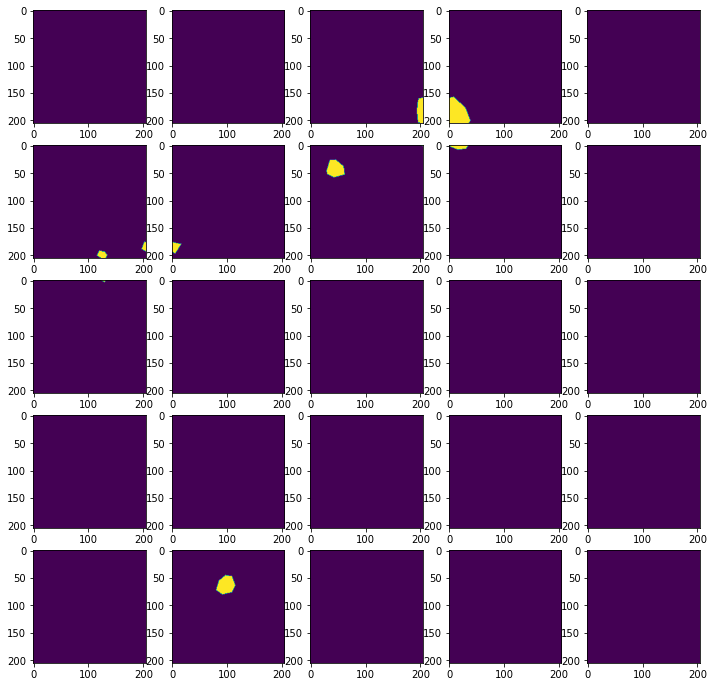

In [65]:
l_grid = 5

lenght = np.asarray(Image.open(ALL_IMAGES[0])).shape[0]
tile_lenght = lenght//l_grid+1

# tiler = Tiler(image_shape=padded_image.shape, tile_shape=(128, 128, 3),
#               overlap=(64, 64, 0), channel_dimension=2)

image_tiler = Tiler(image_shape=(lenght, lenght, 3),
                   tile_shape=(tile_lenght, tile_lenght, 3))

mask_tiler = Tiler(image_shape=(lenght, lenght),
                   tile_shape=(tile_lenght, tile_lenght))

i = np.random.randint(0, len(ALL_IMAGES))
img_p = ALL_IMAGES[i]
    
    
img = Image.open(img_p)
img = np.asarray(img)

name = img_p.name
name = os.path.splitext(name)[0]
mask = Image.open(soft_masks_folder / f"{name}_mask.png")
mask = np.asarray(mask)

fig0, ax0 = plt.subplots(1, 2)
ax0[0].imshow(img)
ax0[1].imshow(mask)

fig, ax = plt.subplots(l_grid, l_grid, figsize=(12,12))
fig1, ax1 = plt.subplots(l_grid, l_grid, figsize=(12,12))

for i in range(l_grid**2):
    ax[i//l_grid][i%l_grid].imshow(image_tiler.get_tile(img, i))
    ax1[i//l_grid][i%l_grid].imshow(mask_tiler.get_tile(mask, i))

---

In [63]:
from IPython.display import clear_output

def create_tiling(IMAGES, masks_folder, tiled_image_path, tiled_mask_path):
    assert not any(tiled_image_path.iterdir()) or not any(tiled_mask_path.iterdir()), "Tiled folders not empty "
    
    lenght = np.asarray(Image.open(IMAGES[0])).shape[0]

    image_tiler = Tiler(image_shape=(lenght, lenght, 3),
                       tile_shape=(lenght//l_grid+1, lenght//l_grid+1, 3))

    mask_tiler = Tiler(image_shape=(lenght, lenght),
                       tile_shape=(lenght//l_grid, lenght//l_grid))

    for i, img_p in enumerate(IMAGES):
        clear_output(wait=True)
        print(f'Writing image: ({i+1}/{len(IMAGES)})')
        img = Image.open(img_p)
        img = np.asarray(img)

        name = img_p.name
        name = os.path.splitext(name)[0]
        mask = Image.open(masks_folder / f"{name}_mask.png")
        mask = np.asarray(mask)

        for i in range(l_grid**2):
            img_name = tiled_image_path / f'{name}_{i:02d}.jpg'
#             print(name, len(name))
            mask_name = tiled_mask_path / f'{name}_{i:02d}_mask.png'
            Image.fromarray(image_tiler.get_tile(img, i)).save(img_name)
            Image.fromarray(mask_tiler.get_tile(mask, i)).save(mask_name)
        

    print(f'({len(os.listdir(tiled_image_path))}, {len(os.listdir(tiled_mask_path))}) images, masks saved.')

In [64]:
create_tiling(ALL_IMAGES, soft_masks_folder, tiled_image_path, tiled_mask_path)

Writing image: (857/857)
(21425, 21425) images, masks saved.


## Test dataset

In [17]:
t_IMAGES = sorted(tiled_image_path.glob("*.jpg"))
t_MASKS = sorted(tiled_mask_path.glob("*.png"))

for i,m in zip(t_IMAGES, t_MASKS):
    if os.path.splitext(i.name)[0] != os.path.splitext(m.name)[0][:-5]: print('error!')

In [60]:
test_images_folder = ROOT / "images_original/luglio_2020/"
test_masks_folder = ROOT / "masks/luglio_2020/"

tiled_image_test = ROOT / "images_original/tiled_test_images"
tiled_mask_test = ROOT / "masks/tiled_test_masks"

for fold in [tiled_image_test, tiled_mask_test]:
    if os.path.exists(fold):
        shutil.rmtree(fold)
    os.mkdir(fold)

TEST_IMAGES = sorted(test_images_folder.glob("*.jpg"))
TEST_MASKS = sorted(test_masks_folder.glob("*.png"))

print(f"Masks:{len(TEST_MASKS)}")
print(f"Images:{len(TEST_IMAGES)}")

Masks:160
Images:160


In [61]:
create_tiling(TEST_IMAGES, test_masks_folder, tiled_image_test, tiled_mask_test)

Writing image: (160/160)
TUBI 29-30.07.2020_T4 2 40x9 side B 35
TUBI 29-30.07.2020_T4 2 40x9 side B 35
TUBI 29-30.07.2020_T4 2 40x9 side B 35
TUBI 29-30.07.2020_T4 2 40x9 side B 35
TUBI 29-30.07.2020_T4 2 40x9 side B 35
TUBI 29-30.07.2020_T4 2 40x9 side B 35
TUBI 29-30.07.2020_T4 2 40x9 side B 35
TUBI 29-30.07.2020_T4 2 40x9 side B 35
TUBI 29-30.07.2020_T4 2 40x9 side B 35
TUBI 29-30.07.2020_T4 2 40x9 side B 35
TUBI 29-30.07.2020_T4 2 40x9 side B 35
TUBI 29-30.07.2020_T4 2 40x9 side B 35
TUBI 29-30.07.2020_T4 2 40x9 side B 35
TUBI 29-30.07.2020_T4 2 40x9 side B 35
TUBI 29-30.07.2020_T4 2 40x9 side B 35
TUBI 29-30.07.2020_T4 2 40x9 side B 35
(2560, 2560) images, masks saved.


In [62]:
t_IMAGES = sorted(tiled_image_test.glob("*.jpg"))
t_MASKS = sorted(tiled_mask_test.glob("*.png"))

for i,m in zip(t_IMAGES, t_MASKS):
    if os.path.splitext(i.name)[0] != os.path.splitext(m.name)[0][:-5]: print('error!')